In [1]:
# Colab: Make sure you select 'Runtime -> Change runtime type -> Hardware Accelerator: GPU' 

In [2]:
# Install PGBM and ninja for CUDA extension compilation. 
%pip install pgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
#%% Load packages
import torch
from pgbm.torch import PGBM
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

c:\Users\ospra\miniconda3\envs\phd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using C:\Users\ospra\AppData\Local\torch_extensions\torch_extensions\Cache\py310_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\ospra\AppData\Local\torch_extensions\torch_extensions\Cache\py310_cu117\split_decision\build.ninja...
Building extension module split_decision...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module split_decision...
Using C:\Users\ospra\AppData\Local\torch_extensions\torch_extensions\Cache\py310_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module split_decision, skipping build step...
Loading extension module split_decis

In [4]:
#%% Objective for pgbm
def mseloss_objective(yhat, y, levels=None):
    gradient = (yhat - y)
    hessian = torch.ones_like(yhat)

    return gradient, hessian

def rmseloss_metric(yhat, y, levels=None):
    loss = (yhat - y).pow(2).mean().sqrt()

    return loss

In [5]:
#%% Load data
X, y = fetch_california_housing(return_X_y=True)
params = {'device':'gpu'}

In [6]:
#%% Train pgbm
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
train_data = (X_train, y_train)
test_data = (X_test, y_test)
# Train on set 
model = PGBM()  
model.train(train_data, objective=mseloss_objective, metric=rmseloss_metric, params=params)
#% Point and probabilistic predictions. By default, 100 probabilistic estimates are created
yhat_point = model.predict(test_data[0])
yhat_dist = model.predict_dist(test_data[0])
# Scoring
rmse = model.metric(yhat_point.cpu(), test_data[1])
crps = model.crps_ensemble(yhat_dist, test_data[1]).mean()    
# Print final scores
print(f'RMSE PGBM: {rmse:.2f}')
print(f'CRPS PGBM: {crps:.2f}')

Training on GPU
Estimator 0/100, Train metric: 1.0793
Estimator 1/100, Train metric: 1.0170
Estimator 2/100, Train metric: 0.9632
Estimator 3/100, Train metric: 0.9149
Estimator 4/100, Train metric: 0.8721
Estimator 5/100, Train metric: 0.8344
Estimator 6/100, Train metric: 0.7994
Estimator 7/100, Train metric: 0.7701
Estimator 8/100, Train metric: 0.7444
Estimator 9/100, Train metric: 0.7218
Estimator 10/100, Train metric: 0.6999
Estimator 11/100, Train metric: 0.6828
Estimator 12/100, Train metric: 0.6673
Estimator 13/100, Train metric: 0.6531
Estimator 14/100, Train metric: 0.6414
Estimator 15/100, Train metric: 0.6289
Estimator 16/100, Train metric: 0.6196
Estimator 17/100, Train metric: 0.6084
Estimator 18/100, Train metric: 0.5998
Estimator 19/100, Train metric: 0.5906
Estimator 20/100, Train metric: 0.5821
Estimator 21/100, Train metric: 0.5767
Estimator 22/100, Train metric: 0.5673
Estimator 23/100, Train metric: 0.5599
Estimator 24/100, Train metric: 0.5546
Estimator 25/100, T

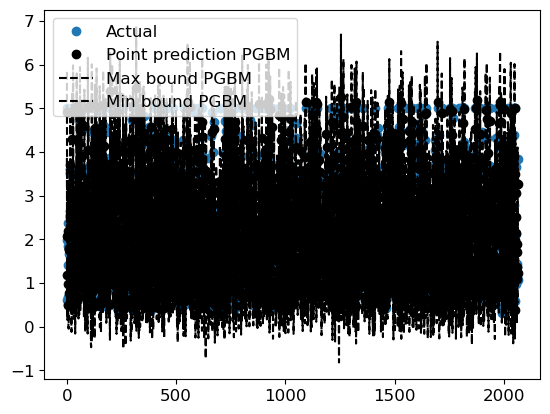

In [7]:
#%% Plot all samples
plt.rcParams.update({'font.size': 12})
plt.plot(y_test, 'o', label='Actual')
plt.plot(yhat_point.cpu(), 'ko', label='Point prediction PGBM')
plt.plot(yhat_dist.cpu().max(dim=0).values, 'k--', label='Max bound PGBM')
plt.plot(yhat_dist.cpu().min(dim=0).values, 'k--', label='Min bound PGBM')
plt.legend()